In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Решаю задачу на GPU в Google Colab.

In [0]:
import sys
sys.path.append('/content/drive/My Drive/lib')

In [0]:
import os
os.chdir("..")

import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from glob import glob
from utils import get_mask
from show import show_img_with_mask
from unet_model import UNet
from train import train_net


import torch
import logging

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split

%matplotlib inline

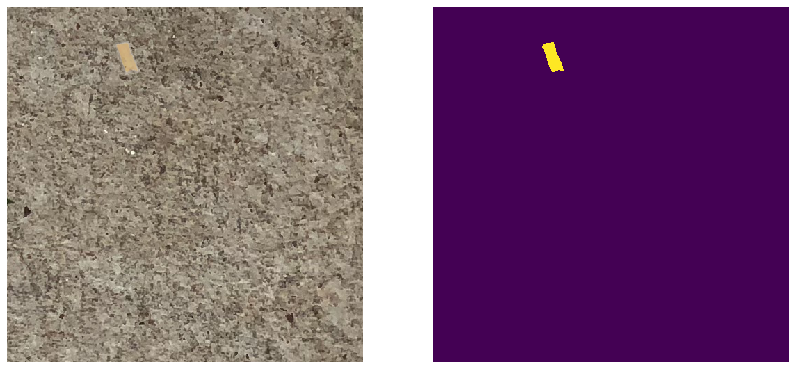

(3, 512, 512)


In [4]:
path = "content/drive/My Drive/data/val"
images = os.listdir(f"{path}/images")
annotations = json.load(open(f"{path}/coco_annotations.json", "r"))
img_id = int(np.random.choice(images).split(".")[0])

img = np.array(Image.open(f"{path}/images/{img_id:08}.png"))
mask = get_mask(img_id, annotations)
show_img_with_mask(img, mask)

Вычисления провожу на GPU. В качестве нейронной сети взята предложенная в статье UNet. Обучение проводится в течение 10 эпох, занимающих около получаса. Как можно заметить, анализируя лог, ошибка на обучении очень сильно и довольно плавно уменьшается. На валидации качество сначала довольно сильно сильно колеблется, затем падает, но со временем начинает расти.

In [5]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

net = UNet(n_channels=3, n_classes=1)
logging.info(f'Network:\n'
                f'\t{net.n_channels} input channels\n'
                f'\t{net.n_classes} output channels (classes)\n'
                f'\t{"Bilinear" if net.bilinear else "Dilated conv"} upscaling')


net.to(device=device)

train_net(net=net,
            epochs=10,
            batch_size=6,
            lr=3.0e-4,
            device=device)

INFO: Using device cuda
INFO: Network:
	3 input channels
	1 output channels (classes)
	Bilinear upscaling
INFO: Creating dataset with 2000 examples
INFO: Creating dataset with 200 examples


INFO: Starting training:
            Epochs:          10
            Batch size:      6
            Learning rate:   0.0003
            Training size:   2000
            Device:          cuda
        
Validation round:  99%|█████████▉| 198/200 [00:07<00:00, 31.68img/s]
                                                                    INFO: Validation Dice Coeff: 1.47024348706007
Validation round:  99%|█████████▉| 198/200 [00:07<00:00, 31.70img/s]
                                                                    INFO: Validation Dice Coeff: 1.3063809737563132
Validation round:  99%|█████████▉| 198/200 [00:07<00:00, 31.70img/s]
                                                                    INFO: Validation Dice Coeff: 1.3063809737563132
Validation round:  99%|█████████▉| 198/200 [00:07<00:00, 31.25img/s]
                                                                    INFO: Validation Dice Coeff: 1.3063809737563132
Validation round:  99%|█████████▉| 198/200 [00:07<00:00, 31.5

In [0]:
from torchvision import transforms
from dataset import BasicDataset

def predict_img(net, img_id, device, out_threshold=0.5):
    net.eval()

    img = torch.from_numpy(np.array(Image.open(f"{path}/images/{img_id:08}.png")).transpose((2, 0, 1))[:3])

    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img)

        if net.n_classes > 1:
            probs = F.softmax(output, dim=1)
        else:
            probs = torch.sigmoid(output)

        probs = probs.squeeze(0)

        tf = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(Image.open(f"{path}/images/{img_id:08}.png").size[1]),
                transforms.ToTensor()
            ]
        )

        probs = tf(probs.cpu())
        full_mask = probs.squeeze().cpu().numpy()

    return full_mask > out_threshold

In [0]:
from utils import encode_rle
df = pd.DataFrame(columns = ['img_id', 'rle_mask'])
i = 0

for image in images:
  img_id = int(image.split(".")[0])
  mask = predict_img(net, img_id, device=device, out_threshold=0.5)
  rle_mask = encode_rle(mask)
  df.loc[i] = {'img_id': img_id, 'rle_mask': rle_mask}
  i+=1

df.to_csv(r'/content/drive/My Drive/data/pred_val_template.csv', index = True, header=True)


In [19]:
pd.read_csv('/content/drive/My Drive/data/pred_val_template.csv')

,Unnamed: 0,img_id,rle_mask
0,0,0,1 813 816 509 1330 507 1841 2672 4514 3461 797...
1,1,6,1 213 217 172 391 127 524 42 574 5 589 19 611 ...
2,2,4,1 927 929 511 1441 110716 112159 22613 134773 ...
3,3,7,1 264 267 83 351 197 551 55 608 16 625 38 672 ...
4,4,1,1 96434 96437 510 96950 509 97463 508 97975 50...
...,...,...,...
195,195,193,1 151 153 99 253 101 358 106 465 7 476 64 546 ...
196,196,196,1 772 823 13 840 67 946 338 1340 7 1361 2 1366...
197,197,190,1 98 100 19 124 252 379 2 384 32 417 17 437 27...
198,198,199,1 250 254 159 414 289 706 17 734 27 778 15 800...
